## Overview
VegaFusion supports pre-transforming datasets within a Vega Spec and then extracting the transformed datasets as pandas DataFrames.

**Note**: This is fairly low-level functionality that is the foundation of the VegaFusion `vf.transformed_data` function. It is designed to be a building block for larger Vega systems.

In [1]:
# imports
import json
from altair.vega import vega
import vegafusion as vf
import pandas as pd

local_tz = "UTC"

## Example 1: JSON url dataset
Consider a simple Vega-Lite histogram like the example at https://vega.github.io/vega-lite/examples/histogram.html

```json
{
  "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
  "data": {"url": "https://raw.githubusercontent.com/vega/vega-datasets/master/data/movies.json"},
  "mark": "bar",
  "encoding": {
    "x": {
      "bin": true,
      "field": "IMDB Rating"
    },
    "y": {"aggregate": "count"}
  }
}

```

This compiles down into the following Vega specification:

In [2]:
full_spec = json.loads(r"""
{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "background": "white",
  "padding": 5,
  "width": 200,
  "height": 200,
  "style": "cell",
  "data": [
    {
      "name": "source_0",
      "url": "https://raw.githubusercontent.com/vega/vega-datasets/master/data/movies.json",
      "format": {"type": "json"},
      "transform": [
        {
          "type": "extent",
          "field": "IMDB Rating",
          "signal": "bin_maxbins_10_IMDB_Rating_extent"
        },
        {
          "type": "bin",
          "field": "IMDB Rating",
          "as": [
            "bin_maxbins_10_IMDB Rating",
            "bin_maxbins_10_IMDB Rating_end"
          ],
          "signal": "bin_maxbins_10_IMDB_Rating_bins",
          "extent": {"signal": "bin_maxbins_10_IMDB_Rating_extent"},
          "maxbins": 10
        },
        {
          "type": "aggregate",
          "groupby": [
            "bin_maxbins_10_IMDB Rating",
            "bin_maxbins_10_IMDB Rating_end"
          ],
          "ops": ["count"],
          "fields": [null],
          "as": ["__count"]
        },
        {
          "type": "filter",
          "expr": "isValid(datum[\"bin_maxbins_10_IMDB Rating\"]) && isFinite(+datum[\"bin_maxbins_10_IMDB Rating\"])"
        }
      ]
    }
  ],
  "marks": [
    {
      "name": "marks",
      "type": "rect",
      "style": ["bar"],
      "from": {"data": "source_0"},
      "encode": {
        "update": {
          "fill": {"value": "#4c78a8"},
          "ariaRoleDescription": {"value": "bar"},
          "description": {
            "signal": "\"IMDB Rating (binned): \" + (!isValid(datum[\"bin_maxbins_10_IMDB Rating\"]) || !isFinite(+datum[\"bin_maxbins_10_IMDB Rating\"]) ? \"null\" : format(datum[\"bin_maxbins_10_IMDB Rating\"], \"\") + \" – \" + format(datum[\"bin_maxbins_10_IMDB Rating_end\"], \"\")) + \"; Count of Records: \" + (format(datum[\"__count\"], \"\"))"
          },
          "x2": {
            "scale": "x",
            "field": "bin_maxbins_10_IMDB Rating",
            "offset": 1
          },
          "x": {"scale": "x", "field": "bin_maxbins_10_IMDB Rating_end"},
          "y": {"scale": "y", "field": "__count"},
          "y2": {"scale": "y", "value": 0}
        }
      }
    }
  ],
  "scales": [
    {
      "name": "x",
      "type": "linear",
      "domain": {
        "signal": "[bin_maxbins_10_IMDB_Rating_bins.start, bin_maxbins_10_IMDB_Rating_bins.stop]"
      },
      "range": [0, {"signal": "width"}],
      "bins": {"signal": "bin_maxbins_10_IMDB_Rating_bins"},
      "zero": false
    },
    {
      "name": "y",
      "type": "linear",
      "domain": {"data": "source_0", "field": "__count"},
      "range": [{"signal": "height"}, 0],
      "nice": true,
      "zero": true
    }
  ],
  "axes": [
    {
      "scale": "y",
      "orient": "left",
      "gridScale": "x",
      "grid": true,
      "tickCount": {"signal": "ceil(height/40)"},
      "domain": false,
      "labels": false,
      "maxExtent": 0,
      "minExtent": 0,
      "ticks": false,
      "zindex": 0
    },
    {
      "scale": "x",
      "orient": "bottom",
      "grid": false,
      "title": "IMDB Rating (binned)",
      "labelFlush": true,
      "labelOverlap": true,
      "tickCount": {"signal": "ceil(width/10)"},
      "zindex": 0
    },
    {
      "scale": "y",
      "orient": "left",
      "grid": false,
      "title": "Count of Records",
      "labelOverlap": true,
      "tickCount": {"signal": "ceil(height/40)"},
      "zindex": 0
    }
  ]
}
""")

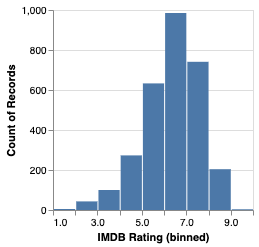

In [3]:
vega(full_spec)

VegaFusion provides a `pre_transform_datasets` method that can be used to load the dataset, perform a variety of data transformations in the Python kernel process, then return the requested datasets as pandas DataFrames

In [4]:
vf.runtime.pre_transform_datasets?

Signature:
vf.runtime.pre_transform_datasets(
    spec,
    datasets,
    local_tz,
    default_input_tz=None,
    inline_datasets=None,
)
Docstring:
Extract the fully evaluated form of the requested datasets from a Vega specification
as pandas DataFrames.

:param spec: A Vega specification
:param datasets: A list with elements that are either:
  - The name of a top-level dataset as a string
  - A two-element tuple where the first element is the name of a dataset as a string
    and the second element is the nested scope of the dataset as a list of integers
:param local_tz: Name of timezone to be considered local. E.g. 'America/New_York'.
    This can be computed for the local system using the tzlocal package and the
    tzlocal.get_localzone_name() function.
:param default_input_tz: Name of timezone (e.g. 'America/New_York') that naive datetime
    strings should be interpreted in. Defaults to `local_tz`.
:param inline_datasets: A dict from dataset names to pandas DataFrames or pyarro

In [5]:
transformed_datasets, warnings = vf.runtime.pre_transform_datasets(full_spec, ["source_0"], local_tz)

In [6]:
print(warnings)

[]


In [7]:
transformed_datasets[0]

,bin_maxbins_10_IMDB Rating,bin_maxbins_10_IMDB Rating_end,__count
0,6.0,7.0,985
1,3.0,4.0,100
2,7.0,8.0,741
3,5.0,6.0,633
4,8.0,9.0,204
5,2.0,3.0,43
6,4.0,5.0,273
7,9.0,10.0,4
8,1.0,2.0,5


## Example 2: DataFrame dataset
Suppose the `movies.json` dataset is already loaded into memory as a pandas `DataFrame`

In [8]:
movies = pd.read_json("https://raw.githubusercontent.com/vega/vega-datasets/master/data/movies.json")
movies.head()

,Title,US Gross,Worldwide Gross,US DVD Sales,Production Budget,Release Date,MPAA Rating,Running Time min,Distributor,Source,Major Genre,Creative Type,Director,Rotten Tomatoes Rating,IMDB Rating,IMDB Votes
0,The Land Girls,146083.0,146083.0,NaN,8000000.0,Jun 12 1998,R,NaN,Gramercy,None,None,None,None,NaN,6.1,1071.0
1,"First Love, Last Rites",10876.0,10876.0,NaN,300000.0,Aug 07 1998,R,NaN,Strand,None,Drama,None,None,NaN,6.9,207.0
2,I Married a Strange Person,203134.0,203134.0,NaN,250000.0,Aug 28 1998,None,NaN,Lionsgate,None,Comedy,None,None,NaN,6.8,865.0
3,Let's Talk About Sex,373615.0,373615.0,NaN,300000.0,Sep 11 1998,None,NaN,Fine Line,None,Comedy,None,None,13.0,NaN,NaN
4,Slam,1009819.0,1087521.0,NaN,1000000.0,Oct 09 1998,R,NaN,Trimark,Original Screenplay,Drama,Contemporary Fiction,None,62.0,3.4,165.0


---

This DataFrame can be provided to `pre_transform_datasets` method as a "named dataset", with name `"movies"`.  When a `DataFrame` is provided as a named dataset, it can be referenced by name from within the Vega specification using a special url syntax. In this case, the moveis dataset can be referenced as `"vegafusion+dataset://movies"`.  Here is the full specification:

In [13]:
full_spec_named = json.loads(r"""
{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "background": "white",
  "padding": 5,
  "width": 200,
  "height": 200,
  "style": "cell",
  "data": [
    {
      "name": "source_0",
      "url": "vegafusion+dataset://movies",
      "transform": [
        {
          "type": "extent",
          "field": "IMDB Rating",
          "signal": "bin_maxbins_10_IMDB_Rating_extent"
        },
        {
          "type": "bin",
          "field": "IMDB Rating",
          "as": [
            "bin_maxbins_10_IMDB Rating",
            "bin_maxbins_10_IMDB Rating_end"
          ],
          "signal": "bin_maxbins_10_IMDB_Rating_bins",
          "extent": {"signal": "bin_maxbins_10_IMDB_Rating_extent"},
          "maxbins": 10
        },
        {
          "type": "aggregate",
          "groupby": [
            "bin_maxbins_10_IMDB Rating",
            "bin_maxbins_10_IMDB Rating_end"
          ],
          "ops": ["count"],
          "fields": [null],
          "as": ["__count"]
        },
        {
          "type": "filter",
          "expr": "isValid(datum[\"bin_maxbins_10_IMDB Rating\"]) && isFinite(+datum[\"bin_maxbins_10_IMDB Rating\"])"
        }
      ]
    }
  ],
  "marks": [
    {
      "name": "marks",
      "type": "rect",
      "style": ["bar"],
      "from": {"data": "source_0"},
      "encode": {
        "update": {
          "fill": {"value": "#4c78a8"},
          "ariaRoleDescription": {"value": "bar"},
          "description": {
            "signal": "\"IMDB Rating (binned): \" + (!isValid(datum[\"bin_maxbins_10_IMDB Rating\"]) || !isFinite(+datum[\"bin_maxbins_10_IMDB Rating\"]) ? \"null\" : format(datum[\"bin_maxbins_10_IMDB Rating\"], \"\") + \" – \" + format(datum[\"bin_maxbins_10_IMDB Rating_end\"], \"\")) + \"; Count of Records: \" + (format(datum[\"__count\"], \"\"))"
          },
          "x2": {
            "scale": "x",
            "field": "bin_maxbins_10_IMDB Rating",
            "offset": 1
          },
          "x": {"scale": "x", "field": "bin_maxbins_10_IMDB Rating_end"},
          "y": {"scale": "y", "field": "__count"},
          "y2": {"scale": "y", "value": 0}
        }
      }
    }
  ],
  "scales": [
    {
      "name": "x",
      "type": "linear",
      "domain": {
        "signal": "[bin_maxbins_10_IMDB_Rating_bins.start, bin_maxbins_10_IMDB_Rating_bins.stop]"
      },
      "range": [0, {"signal": "width"}],
      "bins": {"signal": "bin_maxbins_10_IMDB_Rating_bins"},
      "zero": false
    },
    {
      "name": "y",
      "type": "linear",
      "domain": {"data": "source_0", "field": "__count"},
      "range": [{"signal": "height"}, 0],
      "nice": true,
      "zero": true
    }
  ],
  "axes": [
    {
      "scale": "y",
      "orient": "left",
      "gridScale": "x",
      "grid": true,
      "tickCount": {"signal": "ceil(height/40)"},
      "domain": false,
      "labels": false,
      "maxExtent": 0,
      "minExtent": 0,
      "ticks": false,
      "zindex": 0
    },
    {
      "scale": "x",
      "orient": "bottom",
      "grid": false,
      "title": "IMDB Rating (binned)",
      "labelFlush": true,
      "labelOverlap": true,
      "tickCount": {"signal": "ceil(width/10)"},
      "zindex": 0
    },
    {
      "scale": "y",
      "orient": "left",
      "grid": false,
      "title": "Count of Records",
      "labelOverlap": true,
      "tickCount": {"signal": "ceil(height/40)"},
      "zindex": 0
    }
  ]
}
""")

In [14]:
transformed_datasets, warnings = vf.runtime.pre_transform_datasets(
    full_spec_named, ["source_0"], local_tz, inline_datasets=dict(movies=movies)
)

In [15]:
print(warnings)

[]


In [16]:
transformed_datasets[0]

,bin_maxbins_10_IMDB Rating,bin_maxbins_10_IMDB Rating_end,__count
0,6.0,7.0,985
1,3.0,4.0,100
2,7.0,8.0,741
3,5.0,6.0,633
4,8.0,9.0,204
5,2.0,3.0,43
6,4.0,5.0,273
7,9.0,10.0,4
8,1.0,2.0,5
